<a href="https://colab.research.google.com/github/mchivuku/csb659-project/blob/master/Vanilla_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install tqdm six

!pip install bokeh
!pip install tensorboard
!pip install livelossplot
!pip install tensorboard

## Connect To Google Drive - Project Folder

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
%cd /content/drive/My\ Drive/Masters-DS/CSCI-B659/project/examples/dcgan

/content/drive/My Drive/Masters-DS/CSCI-B659/project/examples/dcgan


## Import

In [26]:
# Importing the libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import os
import numpy as np
## Plotting libraries

from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d
from livelossplot import PlotLosses

import matplotlib.pyplot as plt 
plt.style.use('ggplot')

print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
print(torch.cuda.is_available())

is_cuda = torch.cuda.is_available()
device = torch.device ( "cuda:0" if torch.cuda.is_available () else "cpu" )



Torch 1.0.1.post2 CUDA 10.0.130
Device: cuda:0
True


## Helper functions

In [0]:
class_names = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
"""
Show image
"""
def imshow(img, title="None"):
  img = img.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean # normalize
  img = np.clip(img, 0, 1) # clip image
  plt.figure(figsize=(16,4))
  plt.axis('off')
  plt.imshow(img)
  
  if title is not None:
    plt.title(title)
  
"""
Show image grid
"""

def plot_grid(inputs, classes):
  # make grid from batch
  out = torchvision.utils.make_grid(inputs, 10, 10)
  imshow(out, title="")
  print([class_names[x] for x in classes])
  

## Data Loader

In [0]:
path=""

transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(os.path.join(path,"../vae/MNIST/data"),train=True,transform=transformation,download=True)
test_dataset = datasets.MNIST(os.path.join(path,"../vae/MNIST/data"),train=False,transform=transformation,download=True)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=128,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=128,shuffle=True)

['7 - seven', '1 - one', '6 - six', '8 - eight', '6 - six', '4 - four', '5 - five', '4 - four', '6 - six', '8 - eight', '8 - eight', '0 - zero', '3 - three', '4 - four', '0 - zero', '1 - one', '5 - five', '6 - six', '9 - nine', '9 - nine', '3 - three', '5 - five', '9 - nine', '1 - one', '6 - six', '5 - five', '3 - three', '6 - six', '1 - one', '9 - nine', '9 - nine', '1 - one', '5 - five', '1 - one', '6 - six', '0 - zero', '0 - zero', '1 - one', '3 - three', '4 - four', '0 - zero', '1 - one', '0 - zero', '8 - eight', '2 - two', '1 - one', '1 - one', '8 - eight', '3 - three', '8 - eight', '1 - one', '8 - eight', '0 - zero', '3 - three', '3 - three', '5 - five', '0 - zero', '9 - nine', '3 - three', '3 - three', '9 - nine', '7 - seven', '0 - zero', '2 - two', '4 - four', '1 - one', '6 - six', '0 - zero', '1 - one', '9 - nine', '3 - three', '4 - four', '1 - one', '6 - six', '7 - seven', '7 - seven', '2 - two', '8 - eight', '2 - two', '2 - two', '2 - two', '0 - zero', '8 - eight', '7 - seve

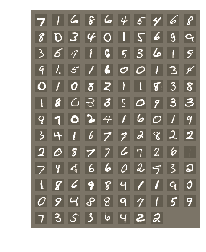

In [30]:

inputs, classes = next(iter(train_loader))
plot_grid(inputs, classes)

## Tensor board utilities

In [0]:
import tensorflow as tf
import numpy as np
import scipy.misc 
from PIL import Image 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x

## Import tensor flow library
class TensorBoardLogger(object):
  
  """
  Initialize the summary writer
  """
  def __init__(self, log_dir):
    "create summary writer"
    self.writer = tf.summary.FileWriter(log_dir)
  
  """
  Add scalar
  """
  def scalar_summary(self, tag, value, step):
    summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
    self.writer.add_summary(summary,step)
    
  """
  Add images
  """
  def image_summary(self, tag, images, step):
    """Log a list of images."""

    img_summaries = []
    for i, img in enumerate(images):
        s = BytesIO()
        
        new_p = Image.fromarray(img)
        if new_p.mode != 'L':
          new_p = new_p.convert('L')
    
        new_p.save(s, format="png")

        # Create an Image object
        img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                   height=img.shape[0],
                                   width=img.shape[1])
        # Create a Summary value
        img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

    # Create and write Summary
    summary = tf.Summary(value=img_summaries)
    self.writer.add_summary(summary, step)
        
  def histo_summary(self, tag, values, step, bins=1000):
      """Log a histogram of the tensor of values."""

      # Create a histogram using numpy
      counts, bin_edges = np.histogram(values, bins=bins)

      # Fill the fields of the histogram proto
      hist = tf.HistogramProto()
      hist.min = float(np.min(values))
      hist.max = float(np.max(values))
      hist.num = int(np.prod(values.shape))
      hist.sum = float(np.sum(values))
      hist.sum_squares = float(np.sum(values**2))

      # Drop the start of the first bin
      bin_edges = bin_edges[1:]

      # Add bin edges and counts
      for edge in bin_edges:
          hist.bucket_limit.append(edge)
      for c in counts:
          hist.bucket.append(c)

      # Create and write Summary
      summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
      self.writer.add_summary(summary, step)
      self.writer.flush()

In [33]:
LOG_DIR = './logs/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)


! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-03-12 21:56:00--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.72.145.109, 52.72.250.2, 52.71.139.107, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.72.145.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14893410 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  14.20M  4.02MB/s    in 3.5s    

2019-03-12 21:56:04 (4.02 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [14893410/14893410]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   
https://ce982c38.ngrok.io


## Running Average

In [0]:
class RunningAverage ():
    """A simple class that maintains the running average of a quantity
    Example:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """

    def __init__( self ):
        self.steps = 0
        self.total = 0

    def update( self, val ):
        self.total += val
        self.steps += 1

    def __call__( self ):
        return self.total / float ( self.steps )

## GAN - Network 

A GAN is comprised of two adversarial networks, a discriminator and a generator.

### Discriminator

Discriminator is a linear classifier. In order for a universal function approximator, atleast one hidden layer having Leaky Relu activation function applied on its output.

Leaky Relu - allows gradients to flow backwards through the layer unimpeded. A leaky Relu is like a normal ReLU except that there is a small non-zero output for negative input values

Sigmoid Output:
Stable loss function. - BCEWithLogistsLoss - which combines sigmoid activation function and binary cross entropy loss in one function.

So final output layer should not have activation aplied to it.


In [0]:
class Discriminator(nn.Module):
  
  def __init__(self, input_size, hidden_dim, output_size):
    super(Discriminator,self).__init__()
    
    ## hidden layers
    self.fc1 = nn.Linear(input_size, hidden_dim*4)
    self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
    self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
    
    ## finally fully connected layer
    self.fc4 = nn.Linear(hidden_dim, output_size)
    
    # dropout layer
    self.dropout = nn.Dropout(0.3)
    
    
  def forward(self,x):
    ## flatten the image
    x = x.view(-1,28*28)
    
    x = F.leaky_relu(self.fc1(x),0.2) #
    x = self.dropout(x)
    
    x = F.leaky_relu(self.fc2(x),0.2) #
    x = self.dropout(x)
    
    x = F.leaky_relu(self.fc3(x),0.2) #
    x = self.dropout(x)
    
    out = self.fc4(x) #
    
    return out
    
    

### Generator

Generator is exactly same as discriminator - except we are applying tanh activation to output layer

In [0]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = torch.tanh(self.fc4(x))

        return out

### Model Parameters

In [0]:
params = {
    ## Discriminator params
    
    "input_size": 784,
    "d_output_size":1,
    "d_hidden_size":32,
    
    ## Generator params
    ## latent vector
    "z_size":100,
    "g_output_size":784,
    "g_hidden_size":32
}



In [0]:
D = Discriminator(params.get("input_size"),params.get("d_hidden_size"),params.get("d_output_size"))
G = Generator(params.get("z_size"),params.get("g_hidden_size"),params.get("g_output_size"))

if is_cuda:
  D = D.to(device)
  G = G.to(device)

In [72]:
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3)
)


### Loss functions

d_loss = d_real_loss + d_fake_loss

In [0]:
## Calculate Losses
def real_loss(D_out, smooth = False):
  batch_size  = D_out.size(0)
  if smooth:
    labels = torch.ones(batch_size)*0.9
  else:
    labels = torch.ones(batch_size) ## real labels
  
  labels = labels.to(device)
  ## numerically stable loss
  criterion = nn.BCEWithLogitsLoss()
  # calculate loss
  loss = criterion(D_out.squeeze(),labels)
  return loss



"""
Fake loss - generator outputs
"""
def fake_loss(D_out):
  batch_size = D_out.size(0)
  labels = torch.zeros(batch_size).to(device)
  criterion = nn.BCEWithLogitsLoss()
  # calculate loss
  loss = criterion(D_out.squeeze(),labels)
  return loss
  

### Optimizers

In [0]:
import torch.optim as optim

lr = 0.002

## two optimizers
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(),lr)

## Training

Training
Training will involve alternating between training the discriminator and the generator. We'll use our functions real_loss and fake_loss to help us calculate the discriminator losses in all of the following cases.

Discriminator training
Compute the discriminator loss on real, training images
Generate fake images
Compute the discriminator loss on fake, generated images
Add up real and fake loss
Perform backpropagation + an optimization step to update the discriminator's weights
Generator training
Generate fake images
Compute the discriminator loss on fake images, using flipped labels!
Perform backpropagation + an optimization step to update the generator's weights

In [73]:
import pickle as pkl
import torch.nn.functional as F

## Tensorboard logger
logger = TensorBoardLogger("./logs") 

## training params
num_epochs = 10

## samples
samples = []
losses = []

log_interval = 300

sample_size = 16
fixed_z = np.random.uniform(-1,1,size=(sample_size,params.get("z_size")))
fixed_z  = torch.from_numpy(fixed_z).float()
fixed_z = fixed_z.to(device)

D.train()
G.train()

for epoch in range(num_epochs):
  for batch_i, (real_images, _) in enumerate(train_loader):
    
    batch_size = real_images.size(0)
    
    real_images = real_images*2 - 1 ## rescale
    real_images = Variable(real_images.to(device))
    
    #### Train Discriminator
    d_optimizer.zero_grad()
    
    D_real = D(real_images)
    d_real_loss = real_loss(D_real, smooth = True)
    
    ## Generate fake images
    z = np.random.uniform(-1,1,size=(batch_size,params.get("z_size")))
    z = Variable(torch.from_numpy(z).float()).to(device)
    fake_images  = G(z)
    
    
    ## compute discriminator loss
    D_fake = D(fake_images)
    d_fake_loss = fake_loss(D_fake)
    
    ## total loss of discriminator - real + fake
    d_loss = d_real_loss + d_fake_loss
    d_loss.backward()
    d_optimizer.step()
    
    ## Train Generator
    g_optimizer.zero_grad()
    ## Generate fake images
    z = np.random.uniform(-1,1,size=(batch_size,params.get("z_size")))
    z = Variable(torch.from_numpy(z).float()).to(device)
    fake_images = G(z)
    
    D_fake = D(fake_images)
    g_loss = real_loss(D_fake)
    
    g_loss.backward()
    g_optimizer.step()
    
    if batch_i % log_interval == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))
          
          
    # 1. Log scalar values (scalar summary)
    info = { 'g_loss': g_loss, 'd_loss': d_loss }

    for tag, value in info.items():
      logger.scalar_summary(tag, value, epoch+1)

    # 2. Log values and gradients of the parameters (histogram summary)
    for tag, value in D.named_parameters():
      tag = tag.replace('.', '/')
      logger.histo_summary(tag, value.data.cpu().numpy(), epoch+1)
      logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), epoch+1)
      
    # 2. Log values and gradients of the parameters (histogram summary)
    for tag, value in G.named_parameters():
      tag = tag.replace('.', '/')
      logger.histo_summary(tag, value.data.cpu().numpy(), epoch+1)
      logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), epoch+1)
      

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode
    
    # 3. Log training images (image summary)
    info = { 'images': fake_images.detach().view(-1, 28, 28)[:10].cpu().numpy() }

    for tag, images in info.items():
      logger.image_summary(tag, images, epoch+1)
    
    
    
# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)
    

Epoch [    1/   10] | d_loss: 1.3596 | g_loss: 0.7662
Epoch [    1/   10] | d_loss: 1.3604 | g_loss: 0.7655
Epoch [    2/   10] | d_loss: 1.3588 | g_loss: 0.7655
Epoch [    2/   10] | d_loss: 1.3616 | g_loss: 0.7672
Epoch [    3/   10] | d_loss: 1.3591 | g_loss: 0.7652
Epoch [    3/   10] | d_loss: 1.3619 | g_loss: 0.7659
Epoch [    4/   10] | d_loss: 1.3480 | g_loss: 0.7642
Epoch [    4/   10] | d_loss: 1.3654 | g_loss: 0.7663
Epoch [    5/   10] | d_loss: 1.3572 | g_loss: 0.7676
Epoch [    5/   10] | d_loss: 1.3597 | g_loss: 0.7657
Epoch [    6/   10] | d_loss: 1.3696 | g_loss: 0.7650
Epoch [    6/   10] | d_loss: 1.3517 | g_loss: 0.7670
Epoch [    7/   10] | d_loss: 1.3545 | g_loss: 0.7661
Epoch [    7/   10] | d_loss: 1.3556 | g_loss: 0.7655
Epoch [    8/   10] | d_loss: 1.3509 | g_loss: 0.7645
Epoch [    8/   10] | d_loss: 1.3563 | g_loss: 0.7659
Epoch [    9/   10] | d_loss: 1.3543 | g_loss: 0.7651
Epoch [    9/   10] | d_loss: 1.3563 | g_loss: 0.7652
Epoch [   10/   10] | d_loss

## Loss plots


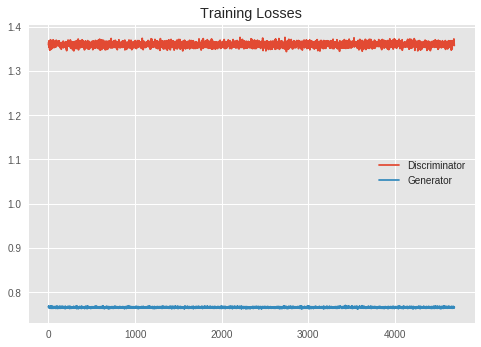

In [74]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Samples



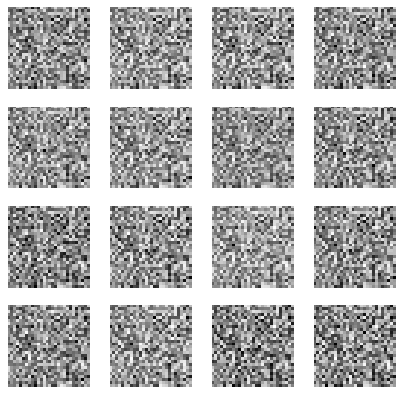

In [77]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        
## Load samples
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)
